## Boilerplate

In [35]:
# Typical imports
import numpy as np
from scipy.spatial import Delaunay
from skimage.draw import polygon2mask
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from pylab import *
import cv2
import math
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:40:20) [Clang 14.0.6 ]


# For updating my helper functions (sometimes you need to run this block twice)

In [2]:
# My own helper functions
import julians_little_helpers 
from julians_little_helpers import * 
# For reloading my helper functions when I make changes to them
import importlib
importlib.reload(julians_little_helpers)

<module 'julians_little_helpers' from '/Users/julian/Code/cs180/proj3/code/julians_little_helpers.py'>

# Part 1: Defining Correspondences
For this I chose to use a picture of myself (the photo I took for my student ID lol) and the given photo of George Clooney. 


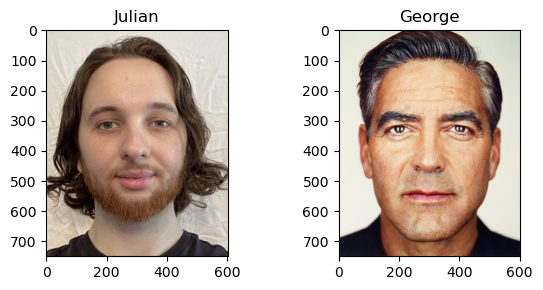

In [3]:
julian = read_im('../data/julian_portrait.jpg')
george = read_im('../data/george.jpg')
Display2Images(julian, george, 'Julian', 'George', 3)

#### Get the points I generated using this website: 
https://inst.eecs.berkeley.edu/~cs194-26/fa22/upload/files/proj3/cs194-26-aex/tool.html

(Thank you to whomever made this!)

In [4]:
# Import the correpsondence data
julian_pts, george_pts = GetPointsFromJSON('../data/julian_portrait_george.json')
julian_pts_xy = np.array(julian_pts)
george_pts_xy = np.array(george_pts)
# Reverse the ordering of the points from (x,y) to (y,x) 😡
julian_pts = np.column_stack((julian_pts_xy[:,1], julian_pts_xy[:,0]))
george_pts = np.column_stack((george_pts_xy[:,1], george_pts_xy[:,0]))

## Display our points and triangulations on our faces.

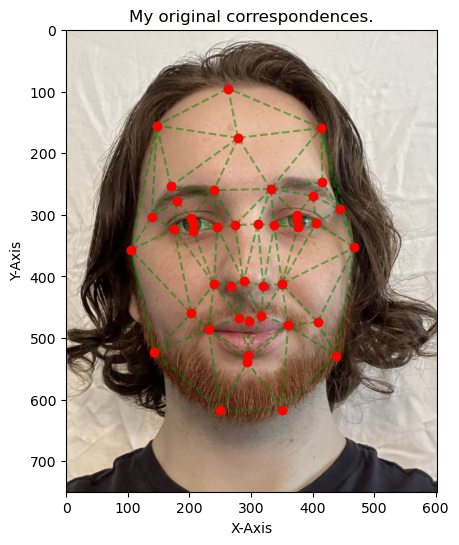

In [5]:
DisplayFaceTrisAndPts(julian, GetTriangulationObject(julian_pts_xy), julian_pts, 'My original correspondences.')

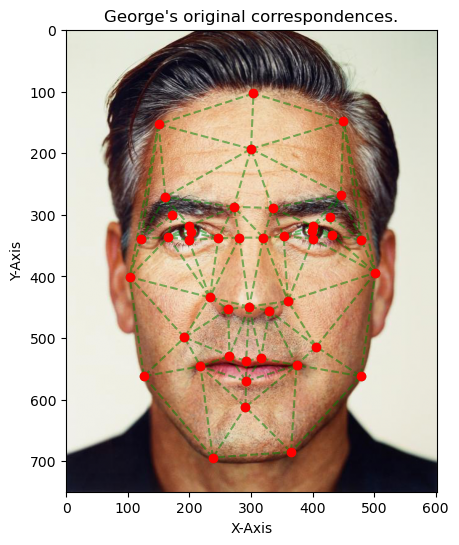

In [6]:
DisplayFaceTrisAndPts(george, GetTriangulationObject(george_pts_xy), george_pts, 'George\'s original correspondences.')

## Get the "mid-way" shape of our faces and compute its Delaunay triangulation.

In [29]:
midway_pts = GetMidwayFace(julian_pts, george_pts)
midway_pts_xy = np.column_stack((midway_pts[:,1], midway_pts[:,0]))
midway_triangulation = Delaunay(midway_pts)

## Showing the average points and its triangulation on our faces.

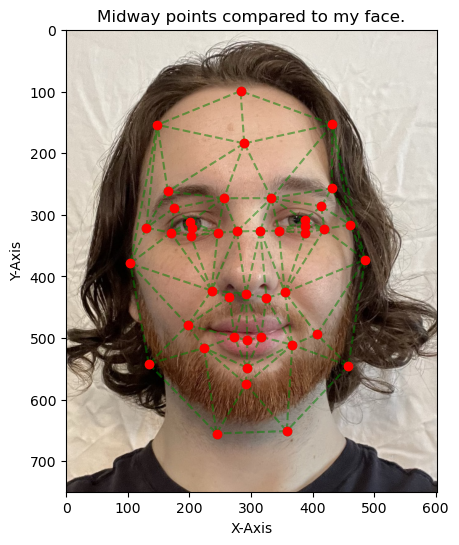

In [31]:
julian_tris = GetTriangulationObject(julian_pts)
DisplayFaceTrisAndPts(julian, GetTriangulationObjectFromExistingDelaunay(midway_pts_xy, midway_triangulation), midway_pts, 'Midway points compared to my face.')

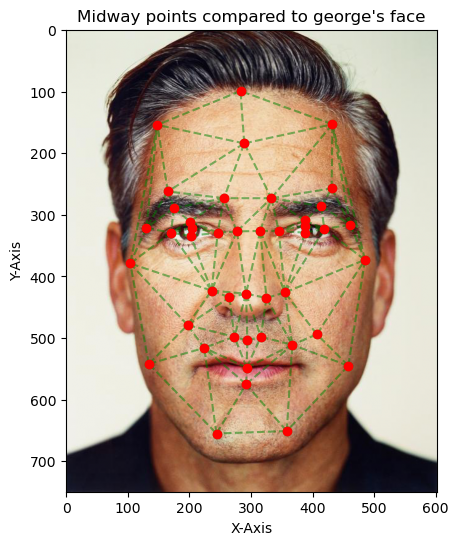

In [32]:
george_tris = GetTriangulationObject(george_pts)
DisplayFaceTrisAndPts(george, GetTriangulationObjectFromExistingDelaunay(midway_pts_xy, midway_triangulation), midway_pts, 'Midway points compared to george\'s face')

# Warp julian's face to george's face shape by inverse warping all pixels based on the inverse transformation matrix of the triangles they are in. 

#### Use a mask using skimage polygon and polygon2mask. You could then use the mask to select only the triangle's pixels, transform that new image, and add these up for all triangles.

In [12]:
from scipy.spatial import Delaunay
julian_delaunay = Delaunay(julian_pts)

'\nprint("")\nfor simplex in julian_delaunay.simplices:\n    print(f"[{julian_delaunay.points[simplex[0]]}, {julian_delaunay.points[simplex[1]]}, {julian_delaunay.points[simplex[2]]}]")\nprint("]")\n'

### How to transform each triangle's pixels? Loop through the triangles, and for each:
1. First, get a binary mask of all of the pixels in the triangle
2. Take the array slice of the image with the binary mask
3. Transform the masked image by that triangle's affine transformation to the corresponding triangle in the target image.
#### Then add up all of these images!


## Compute our delaunay triangulations.

In [36]:
julian_delaunay = Delaunay(julian_pts)
george_delaunay = Delaunay(george_pts)

What I need to do is implement inverse warping. That means looping through all the pixels in the transformed shape, i.e. use the mask of george's triangle, and compute the coordinate in julian's image that correponds to the same point using the inverse of the transformation matrix. Because the resulting inverse coordinte is not necessarily an integer, I need to interpolate the value of the pixel at that coordinate. I can do this using bilinear interpolation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


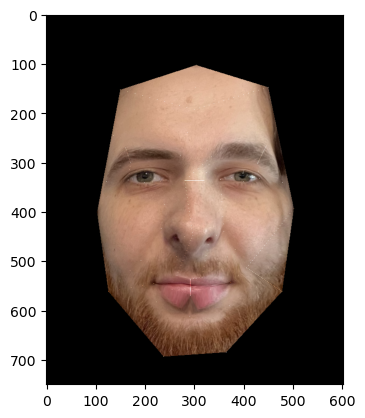

In [21]:
x_dim = np.arange(0, julian.shape[1])
y_dim = np.arange(0, julian.shape[0])

r_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,0], method='linear', bounds_error=False, fill_value=None)
g_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,1], method='linear', bounds_error=False, fill_value=None)
b_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,2], method='linear', bounds_error=False, fill_value=None)

def interpolate_rgb(yx_coord):
    r = r_interpolator(yx_coord)
    g = g_interpolator(yx_coord)
    b = b_interpolator(yx_coord)
    return np.array((r, g, b)).reshape(1,3)

def interpolate_rgb_h(homogenous):
    return interpolate_rgb((homogenous[0], homogenous[1]))

j_tris_transformed_ims = []
# For all triangles in the triangulation:
for i in range(len(julian_delaunay.simplices)):
    triangle_simplex = julian_delaunay.simplices[i]
    # Get the corresponding triangle shape from george's face.
    g_tri_mask_im = polygon2mask(george.shape[:2], george_pts[triangle_simplex])
    # Compute transformation from one of my triangles to the corresponding triangle in george's face.
    j_raw_tri = julian_pts[triangle_simplex]
    g_raw_tri = george_pts[triangle_simplex]
    # Convert triangle points to homogenous coordinates.
    j_tri_pts = ConvertPointsToHomogenous(j_raw_tri)
    g_tri_pts = ConvertPointsToHomogenous(g_raw_tri)
    # Compute affine transfromation matrix from my triangle to george's triangle.
    T = ComputeAffine(j_tri_pts, g_tri_pts)
    # Get the inverse of the transformation matrix.
    T_inv = np.linalg.inv(T)

    # Initialize transformed image to zeros.
    j_tri_t = np.zeros_like(julian)
    # For every pixel coordinate position that is True in the mask of the transformed image (g_mask1)
    for y in range(g_tri_mask_im.shape[0]):
        for x in range(g_tri_mask_im.shape[1]):
            if g_tri_mask_im[y][x]:
                # Get inverse coord
                coord = np.array([y, x, 1])
                inverse_coord = T_inv @ coord
                # Interpolate the value of the pixel at the inverse_coord.
                pixel_value = interpolate_rgb_h(inverse_coord)
                # set this coord to px value of inverse_coord
                j_tri_t[y][x] = pixel_value                 
    j_tris_transformed_ims.append(j_tri_t)

julian_transformed = np.zeros_like(julian)
for im in j_tris_transformed_ims:
    julian_transformed += im
# Add up the masks
# Divide result by the masks.
# Hint: Clamp zeros to ones.

imshow(julian_transformed) 

### Hm, something funky is going on...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


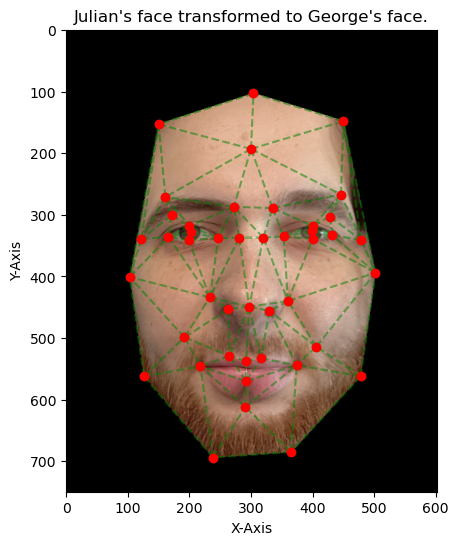

In [37]:
DisplayFaceTrisAndPts(julian_transformed, GetTriangulationObjectFromExistingDelaunay(george_pts_xy, george_delaunay), george_pts, 'Julian\'s face transformed to George\'s face.')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


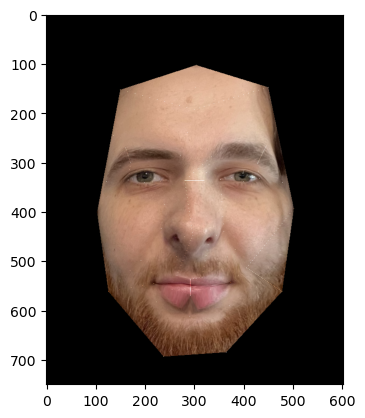

In [34]:
x_dim = np.arange(0, julian.shape[1])
y_dim = np.arange(0, julian.shape[0])

r_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,0], method='linear', bounds_error=False, fill_value=None)
g_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,1], method='linear', bounds_error=False, fill_value=None)
b_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,2], method='linear', bounds_error=False, fill_value=None)

def interpolate_rgb(yx_coord):
    r = r_interpolator(yx_coord)
    g = g_interpolator(yx_coord)
    b = b_interpolator(yx_coord)
    return np.array((r, g, b)).reshape(1,3)

def interpolate_rgb_h(homogenous):
    return interpolate_rgb((homogenous[0], homogenous[1]))

j_tris_transformed_ims = []
masks = []
# For all triangles in the triangulation:
for i in range(len(julian_delaunay.simplices)):
    triangle_simplex = julian_delaunay.simplices[i]
    # Get the corresponding triangle shape from george's face.
    g_tri_mask_im = polygon2mask(george.shape[:2], george_pts[triangle_simplex])
    masks.append(g_tri_mask_im)
    # Compute transformation from one of my triangles to the corresponding triangle in george's face.
    j_raw_tri = julian_pts[triangle_simplex]
    g_raw_tri = george_pts[triangle_simplex]
    # Convert triangle points to homogenous coordinates.
    j_tri_pts = ConvertPointsToHomogenous(j_raw_tri)
    g_tri_pts = ConvertPointsToHomogenous(g_raw_tri)
    # Compute affine transfromation matrix from my triangle to george's triangle.
    T = ComputeAffine(j_tri_pts, g_tri_pts)
    # Get the inverse of the transformation matrix.
    T_inv = np.linalg.inv(T)

    # Initialize transformed image to zeros.
    j_tri_t = np.zeros_like(julian)
    # For every pixel coordinate position that is True in the mask of the transformed image (g_mask1)
    for y in range(g_tri_mask_im.shape[0]):
        for x in range(g_tri_mask_im.shape[1]):
            if g_tri_mask_im[y][x]:
                # Get inverse coord
                coord = np.array([y, x, 1])
                inverse_coord = T_inv @ coord
                # Interpolate the value of the pixel at the inverse_coord.
                pixel_value = interpolate_rgb_h(inverse_coord)
                # set this coord to px value of inverse_coord
                j_tri_t[y][x] = pixel_value                 
    j_tris_transformed_ims.append(j_tri_t)

julian_transformed = np.zeros_like(julian)
for im in j_tris_transformed_ims:
    julian_transformed += im
# Add up the masks
mask_weights = np.zeros_like(j_mask1)
for mask in masks:
    mask_weights += mask
mask_weights[mask_weights < 1] = 1
# Divide the result image by the mask weights (overlapping masks)
julian_transformed[:, :, 0] /= mask_weights
julian_transformed[:, :, 1] /= mask_weights
julian_transformed[:, :, 2] /= mask_weights
imshow(julian_transformed) 

## Ok, at least the mask is properly aligned now. But the points being sampled are totally off.

## I don't have time to do this currently. Going to accelerate the process by going to Jake's office hours later and seeing if he has any clever ideas on what sort of logic problems I'm having.

# IDEA: ADD UP THE masks and divide the end result by that, don't forget to clamp to 1 so that you don't divide by zero


# Compute the morph sequence by writing a function morph(...) 

#### which will have parameters for weighting the interpolation (either more of face 1 or more of face 2). Basically, run the warping procedure we've established up until now with weighted amount of warping between the images and weighted amounts of cross-dissolving. When those variables reach 1 (starting from 0) the morph sequence will be complete.
# TODO: implement this 

# Turn a sequence of computed interpolated images into a GIF which shows the face morph.

In [28]:
# TODO: implement this